 # PtyRAD - PTYchographic Reconstruction with Automatic Differentiation

 Chia-Hao Lee

cl2696@cornell.edu

Created 2024.03.08

# 01. Imports

In [1]:
%reload_ext autoreload
%autoreload 2

from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
import torch
import optuna

GPUID = 0
DEVICE = torch.device('cuda:' + str(GPUID))
print('Execution device: ', DEVICE)
print('PyTorch version: ', torch.__version__)
print('CUDA available: ', torch.cuda.is_available())
print('CUDA version: ', torch.version.cuda)
print('CUDA device:', torch.cuda.get_device_name(GPUID))

Execution device:  cuda:0
PyTorch version:  2.1.0
CUDA available:  True
CUDA version:  12.1
CUDA device: Quadro P5000


c:\Users\chiahao3\anaconda3\envs\ptyrad_optuna\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from ptyrad.initialization import Initializer
from ptyrad.models import PtychoAD
from ptyrad.optimization import CombinedLoss, CombinedConstraint, ptycho_recon, loss_logger
from ptyrad.visualization import plot_forward_pass, plot_scan_positions, plot_summary, plot_pos_grouping, plot_sigmoid_mask, plot_probe_modes, plot_affine_transformation, plot_obj_tilts
from ptyrad.utils import test_loss_fn, select_scan_indices, make_batches, make_recon_params_dict, make_output_folder, save_results, get_blob_size, test_constraint_fn, get_date, get_local_obj_tilts

Importing ptyrad v0.1.0-beta1.3


# 02. Initialize optimization

In [3]:
# from ptyrad.inputs.params_multi_obj import exp_params, source_params
from ptyrad.inputs.params_CNS import exp_params, source_params
# from ptyrad.inputs.params_PSO_128 import exp_params, source_params
# from ptyrad.inputs.params_tBL_WSe2 import exp_params, source_params
# from ptyrad.inputs.params_pymatgen import exp_params, source_params
# from ptyrad.inputs.params_4dstem_ensembles import exp_params, source_params
# from ptyrad.inputs.params_ZSM5_2 import exp_params, source_params

# from ptyrad.inputs.params_BaM_128 import exp_params, source_params
# from ptyrad.inputs.params_BaM_256 import exp_params, source_params
# from ptyrad.inputs.params_eCNS10 import exp_params, source_params
# from ptyrad.inputs.params_HEO_124 import exp_params, source_params
# from ptyrad.inputs.params_tSTO import exp_params, source_params
# from ptyrad.inputs.params_NNO3 import exp_params, source_params
# from ptyrad.inputs.params_Si_128 import exp_params, source_params
# from ptyrad.inputs.params_PdPt import exp_params, source_params
# from ptyrad.inputs.params_NMC_64 import exp_params, source_params
# from ptyrad.inputs.params_NMC_128 import exp_params, source_params
# from ptyrad.inputs.params_tNNO import exp_params, source_params
# from ptyrad.inputs.params_bSTO import exp_params, source_params

In [4]:
init = Initializer(exp_params, source_params).init_all()


### Initializing cache ###
use_cached_obj   = False
use_cached_probe = False
use_cached_pos   = False

### Initializing exp_params ###
Input values are displayed below:
kv: 300
conv_angle: 30
Npix: 164
rbf: None
dx_spec: 0.1406
defocus: -100
c3: 0
z_distance: 1
Nlayer: 10
N_scans: 7134
N_scan_slow: 87
N_scan_fast: 82
scan_step_size: 0.28
scan_flipT: (0, 0, 1)
scan_affine: None
scan_rand_std: 0.15
omode_max: 1
omode_init_occu: {'occu_type': 'uniform', 'init_occu': None}
pmode_max: 2
pmode_init_pows: [0.02]
probe_permute: None
meas_permute: (0, 1, 3, 2)
meas_reshape: (7134, 164, 164)
meas_flipT: None
meas_crop: None
meas_resample: None
meas_add_source_size: None
meas_add_detector_blur: None
meas_add_poisson_noise: None
probe_simu_params: None
Derived values given input exp_params:
kv          = 300 kV
wavelength  = 0.0197 Ang
conv_angle  = 30 mrad
Npix        = 164 px
dk          = 0.0434 Ang^-1
kMax        = 3.5562 Ang^-1
alpha_max   = 70.0124 mrad
dx          = 0.1406 Ang, Nyquist-lim

In [5]:
model_params = {
    'obj_preblur_std'     : None, # scalar(px), None
    'detector_blur_std'   : None, # scalar(px), None
    'lr_params':{
        'obja'            : 5e-4,
        'objp'            : 5e-4,
        'obj_tilts'       : 0, 
        'probe'           : 1e-4, 
        'probe_pos_shifts': 1e-4}}

loss_params = {
    'loss_single': {'state': True, 'weight': 1.0, 'dp_pow': 0.5},
    'loss_poissn': {'state': False, 'weight': 1.0, 'dp_pow':1.0},
    'loss_pacbed': {'state': False, 'weight': 0.5, 'dp_pow': 0.2},
    'loss_sparse': {'state': True, 'weight': 0.1, 'ln_order': 1},
    'loss_simlar': {'state': False, 'weight': 1.0, 'obj_type':'both', 'scale_factor':[1,1,1], 'blur_std':1}
}

constraint_params = {
    'ortho_pmode'   : {'freq': 1},
    'probe_mask_k'  : {'freq': None, 'radius':0.16, 'width':0.02}, # k-radius should be larger than 2*rbf/Npix to avoid cutting out the BF disk
    'fix_probe_int' : {'freq': 1},
    'obj_rblur'     : {'freq': None, 'obj_type':'both', 'kernel_size': 5, 'std':0.4}, # Ideally kernel size is odd and larger than 6std+1 so it decays to 0
    'obj_zblur'     : {'freq': None, 'obj_type':'both', 'kernel_size': 5, 'std':1},
    'kr_filter'     : {'freq': None,    'obj_type':'both', 'radius':0.15, 'width':0.05},
    'kz_filter'     : {'freq': 1,    'obj_type':'both', 'beta':0.3, 'alpha':1},
    'obja_thresh'   : {'freq': None, 'relax':0, 'thresh':[0.8**(1/15), 1.2**(1/15)]},
    'objp_postiv'   : {'freq': 1,    'relax':0},
    'tilt_smooth'   : {'freq': None, 'std':2}
}

constraint_fn = CombinedConstraint(constraint_params, device=DEVICE, verbose=False)
loss_fn = CombinedLoss(loss_params, device=DEVICE)

# 03. Main optimization loop

In [18]:
# 1. Define an objective function to be maximized.
z_range = [0.5, 2]

def optuna_objective(trial, z_range=z_range):
    # 2. Suggest values of the hyperparameters using a trial object.
    
    # Turn off init printing
    init.verbose=False
    
    # Z_distance
    # z_distance = trial.suggest_float('z_distance', 0.5, 2)
    z_distance = trial.suggest_float('z_distance',z_range[0], z_range[1])
    init.init_params['exp_params']['z_distance'] = z_distance
    init.init_H()
    
    # scan_affine
    scale = trial.suggest_float('scale', 0.5, 2)
    asymmetry = trial.suggest_float('asymmetry', -2, 2)
    rotation = trial.suggest_float('rotation', -2,2, step=0.5)
    shear = trial.suggest_float('shear', -10, 10, step=1)
    scan_affine = (scale, asymmetry, rotation, shear)
    init.init_params['exp_params']['scan_affine'] = scan_affine
    init.init_pos()
    init.init_obj() # Update obj initialization because the scan range has changed
    
    # tilt (This will override the current tilts and force it to be a global tilt (2,1))
    tilt_y = trial.suggest_float('tilt_y', -10, 10)
    tilt_x = trial.suggest_float('tilt_x', -10, 10)
    obj_tilts = [[tilt_y, tilt_x]]
    init.init_variables['obj_tilts'] = obj_tilts

    # Create the model    
    model = PtychoAD(init.init_variables, model_params, device=DEVICE, verbose=False)

    # Use model.set_optimizer(new_lr_params) to update the variable flag and optimizer_params
    optimizer = torch.optim.Adam(model.optimizer_params)
    
    # Setup the iter params
    NITER        = 10
    INDICES_MODE = 'center'   # 'full', 'center', 'sub'
    BATCH_SIZE   = 32
    GROUP_MODE   = 'random' # 'random', 'sparse', 'compact' # Note that 'sparse' for 256x256 scan could take more than 10 mins on CPU. PtychoShelves automatically switch to 'random' for Nscans>1e3
    SAVE_ITERS   = 10        # scalar or None

    # Output folder and pre/postfix, note that the needed / and _ are automatically generated
    output_dir   = 'output/CNS/'
    prefix       = get_date(date_format='%Y%m%d')
    postfix      = 'optuna'
    fig_list     = ['loss', 'forward', 'probe_r_amp', 'probe_k_amp', 'probe_k_phase', 'pos'] # 'loss', 'forward', 'probe_r_amp', 'probe_k_amp', 'probe_k_phase', 'pos', 'tilt', or 'all' for all the figures

    pos          = (model.crop_pos + model.opt_probe_pos_shifts).detach().cpu().numpy()
    probe_int    = model.opt_probe[0].abs().pow(2).detach().cpu().numpy()
    dx           = init.init_variables['dx']
    d_out        = get_blob_size(dx, probe_int, output='d90', verbose=False) # d_out unit is in Ang
    indices      = select_scan_indices(init.init_variables['N_scan_slow'], init.init_variables['N_scan_fast'], subscan_slow=None, subscan_fast=None, mode=INDICES_MODE, verbose=False)
    batches      = make_batches(indices, pos, BATCH_SIZE, mode=GROUP_MODE, verbose=False)
    recon_params = make_recon_params_dict(NITER, INDICES_MODE, BATCH_SIZE, GROUP_MODE, SAVE_ITERS)
    output_path  = make_output_folder(output_dir, indices, exp_params, recon_params, model, constraint_params, loss_params, prefix, postfix, show_init=True, verbose=False)

    fig_grouping = plot_pos_grouping(pos, batches, circle_diameter=d_out/dx, diameter_type='90%', dot_scale=1, show_fig=False, pass_fig=True)
    fig_grouping.savefig(output_path + f"/summary_pos_grouping.png")
    
    # Actual iteration loop
    loss_iters = []
    for niter in range(1, NITER+1):
        
        shuffle(batches)
        batch_losses, iter_t = ptycho_recon(batches, model, optimizer, loss_fn, constraint_fn, niter, verbose=False) 
        loss_iter = loss_logger(batch_losses, niter, iter_t, verbose=False)
        loss_iters.append((niter, loss_iter))
        
        ## Saving intermediate results
        if SAVE_ITERS is not None and niter % SAVE_ITERS == 0:
            # Note that `exp_params` stores the initial exp_params, while `model` contains the actual params that could be updated if either meas_crop or meas_resample is not None
            save_results(output_path, model, exp_params, source_params, loss_params, constraint_params, recon_params, loss_iters, iter_t, niter, batch_losses)
            
            ## Saving summary
            plot_summary(output_path, loss_iters, niter, indices, init.init_variables, model, fig_list, show_fig=False, save_fig=True, verbose=False)
            
        
        ## Pruning logic for optuna
        trial.report(loss_iter, niter)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return loss_iter

In [20]:
# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='minimize',
                            pruner=optuna.pruners.HyperbandPruner(),
                            storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
                            study_name="ptyrad",
                            load_if_exists=True)
study.optimize(optuna_objective, n_trials=5)
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

[I 2024-08-15 15:19:01,214] Using an existing study with name 'ptyrad' instead of creating a new one.
[I 2024-08-15 15:20:02,242] Trial 12 pruned. 
[I 2024-08-15 15:20:23,608] Trial 13 pruned. 
[I 2024-08-15 15:20:44,801] Trial 14 pruned. 
[I 2024-08-15 15:20:52,828] Trial 15 pruned. 
[I 2024-08-15 15:21:13,241] Trial 16 pruned. 


In [9]:
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_contour

C:\Users\chiahao3\AppData\Local\Temp\ipykernel_28324\2148839328.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2024-08-15 14:52:48,160] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


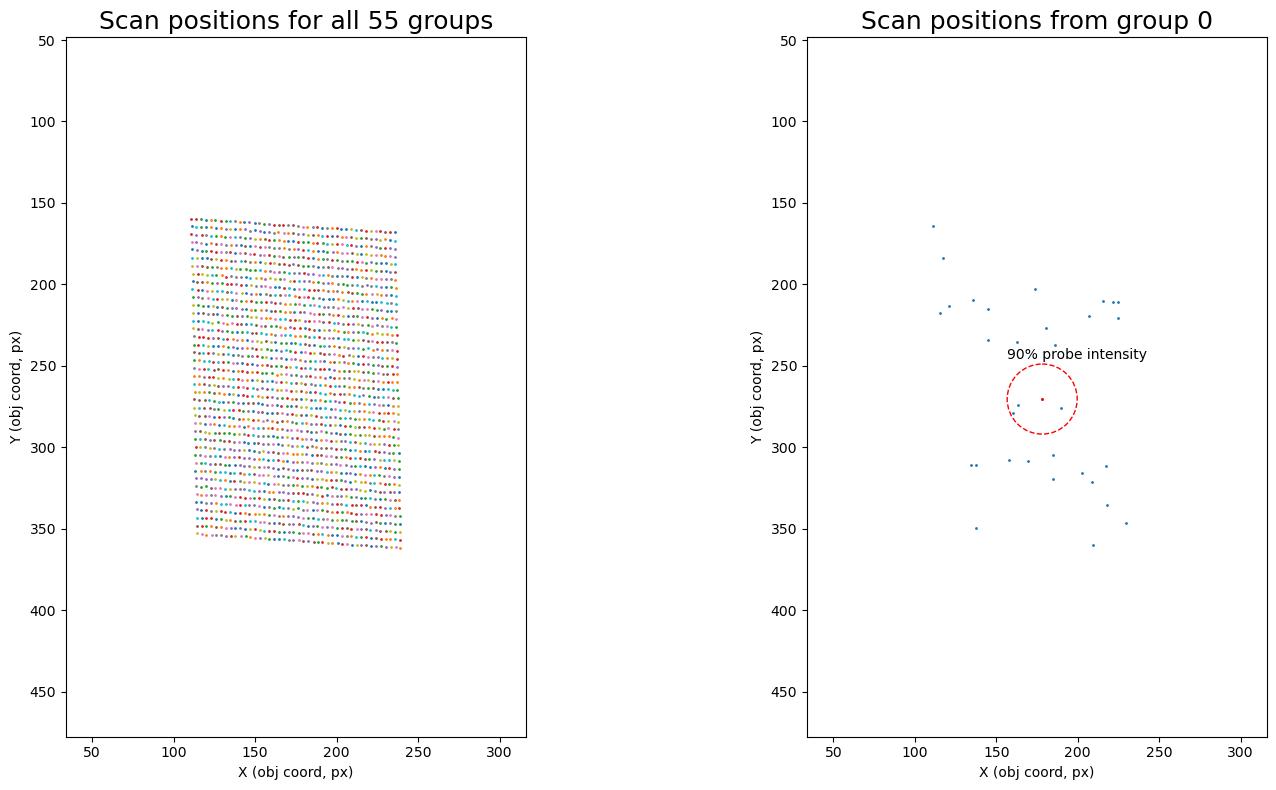

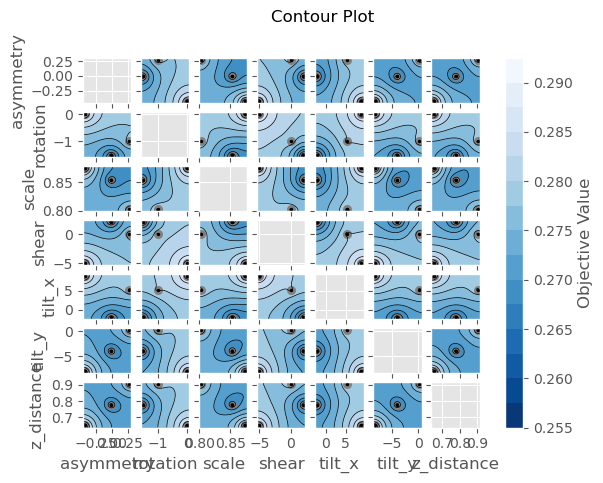

In [10]:
plot_contour(study)
plt.show()

C:\Users\chiahao3\AppData\Local\Temp\ipykernel_28324\1640474764.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


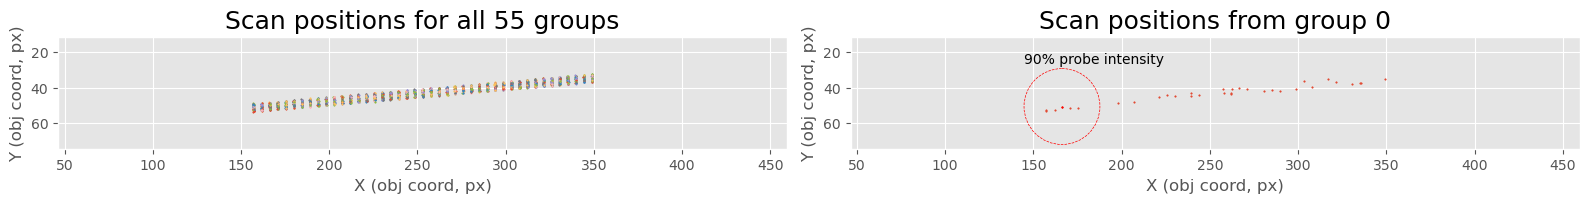

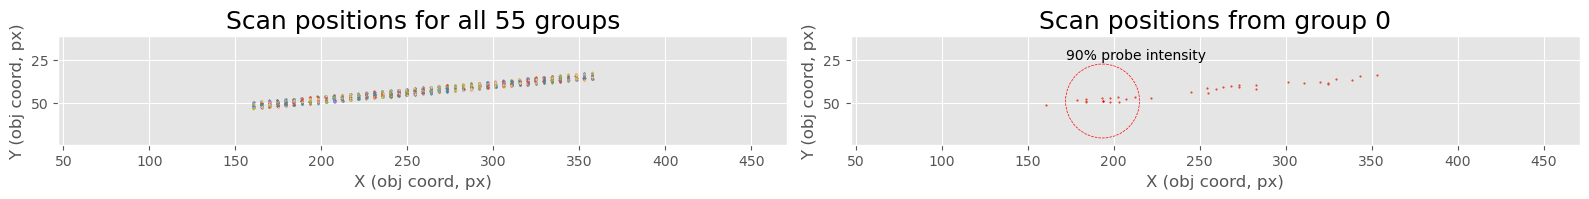

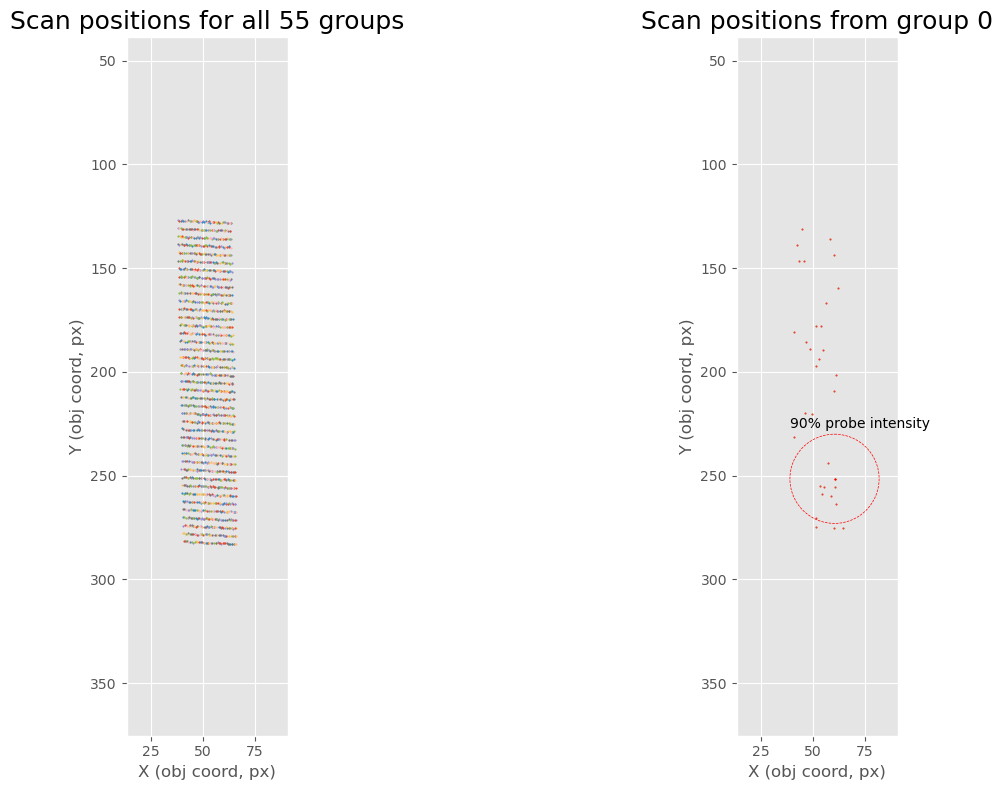

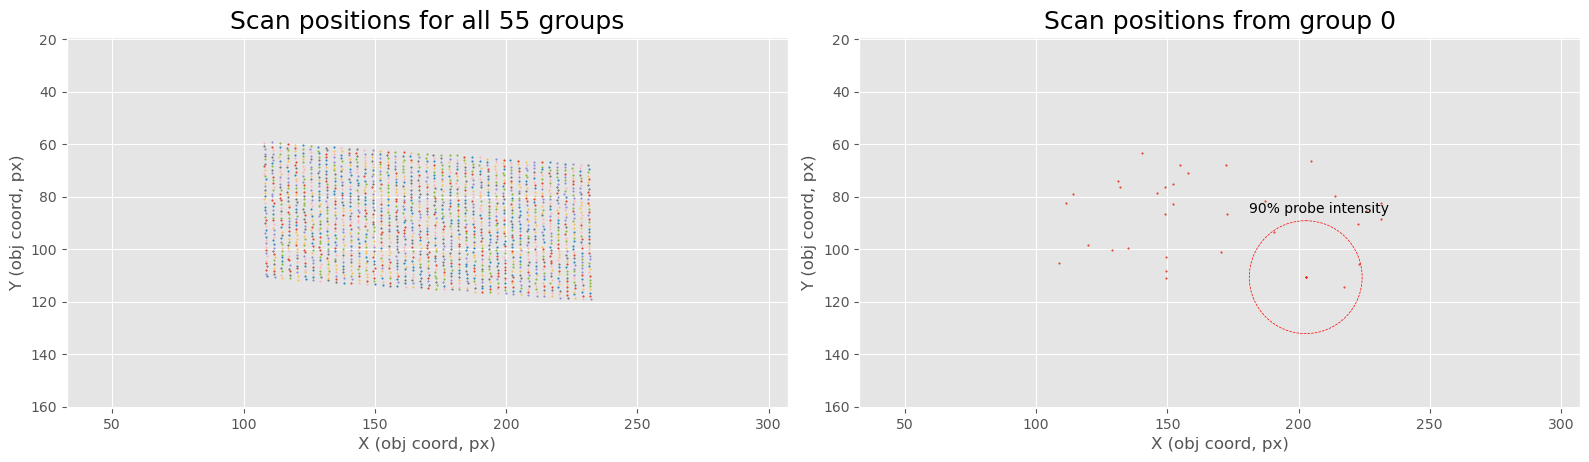

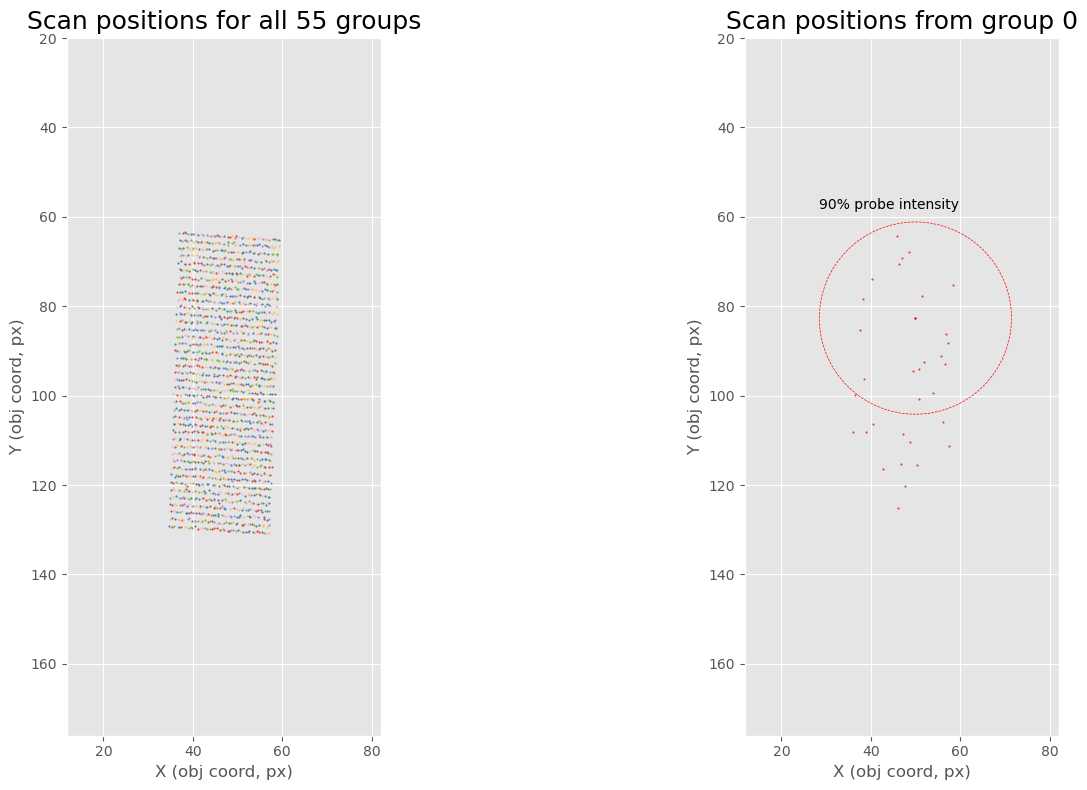

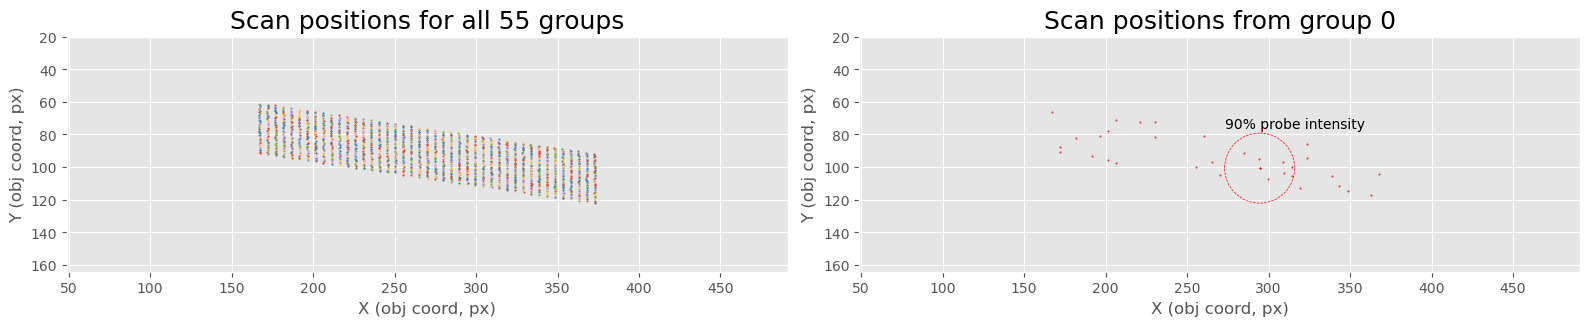

<Figure size 1600x1600 with 0 Axes>

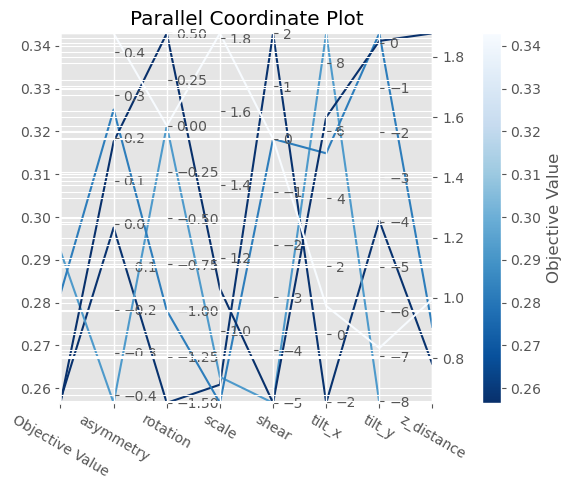

In [21]:
plt.figure(figsize=(16,16))
plot_parallel_coordinate(study)
plt.show()

C:\Users\chiahao3\AppData\Local\Temp\ipykernel_28324\1439563358.py:1: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(study)


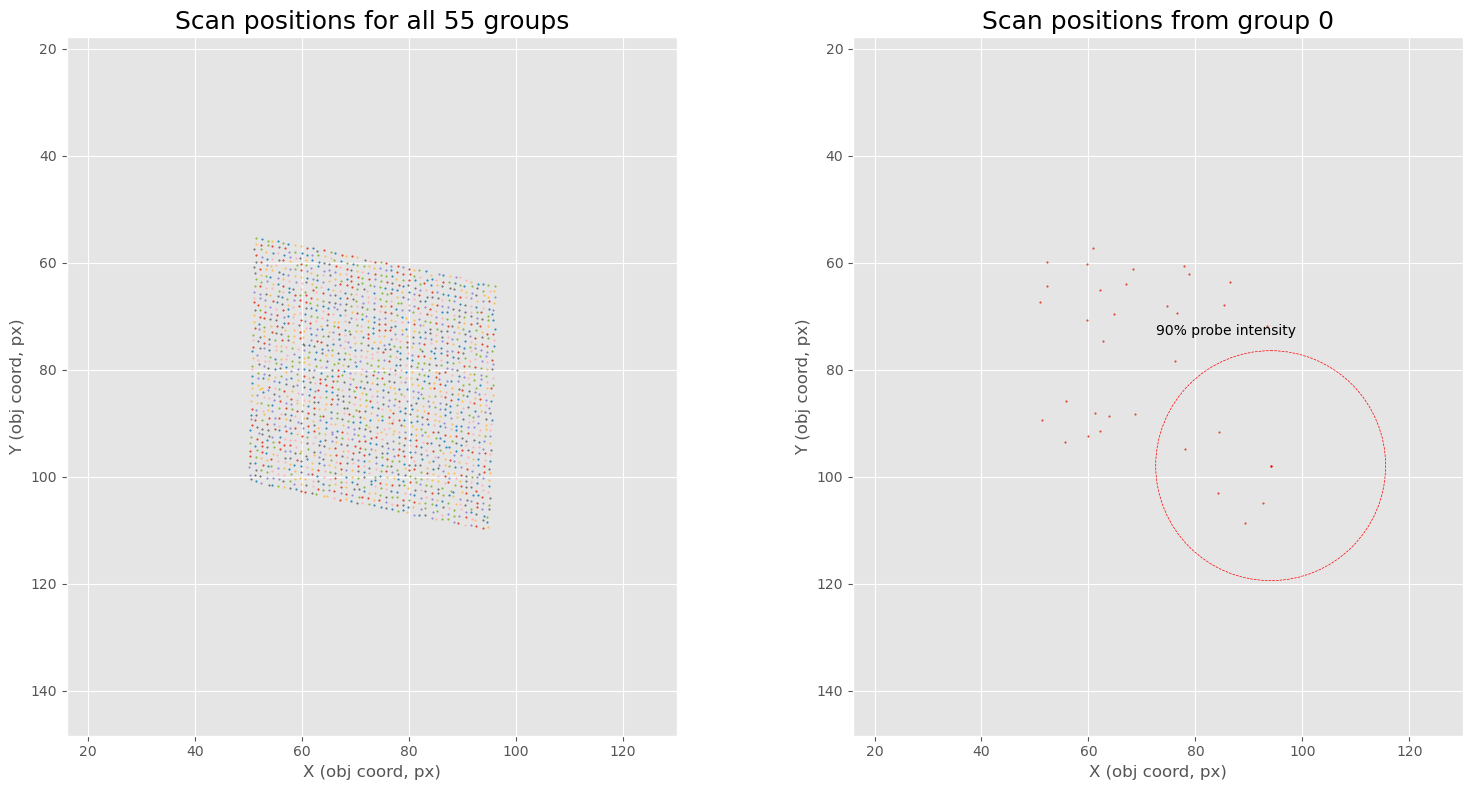

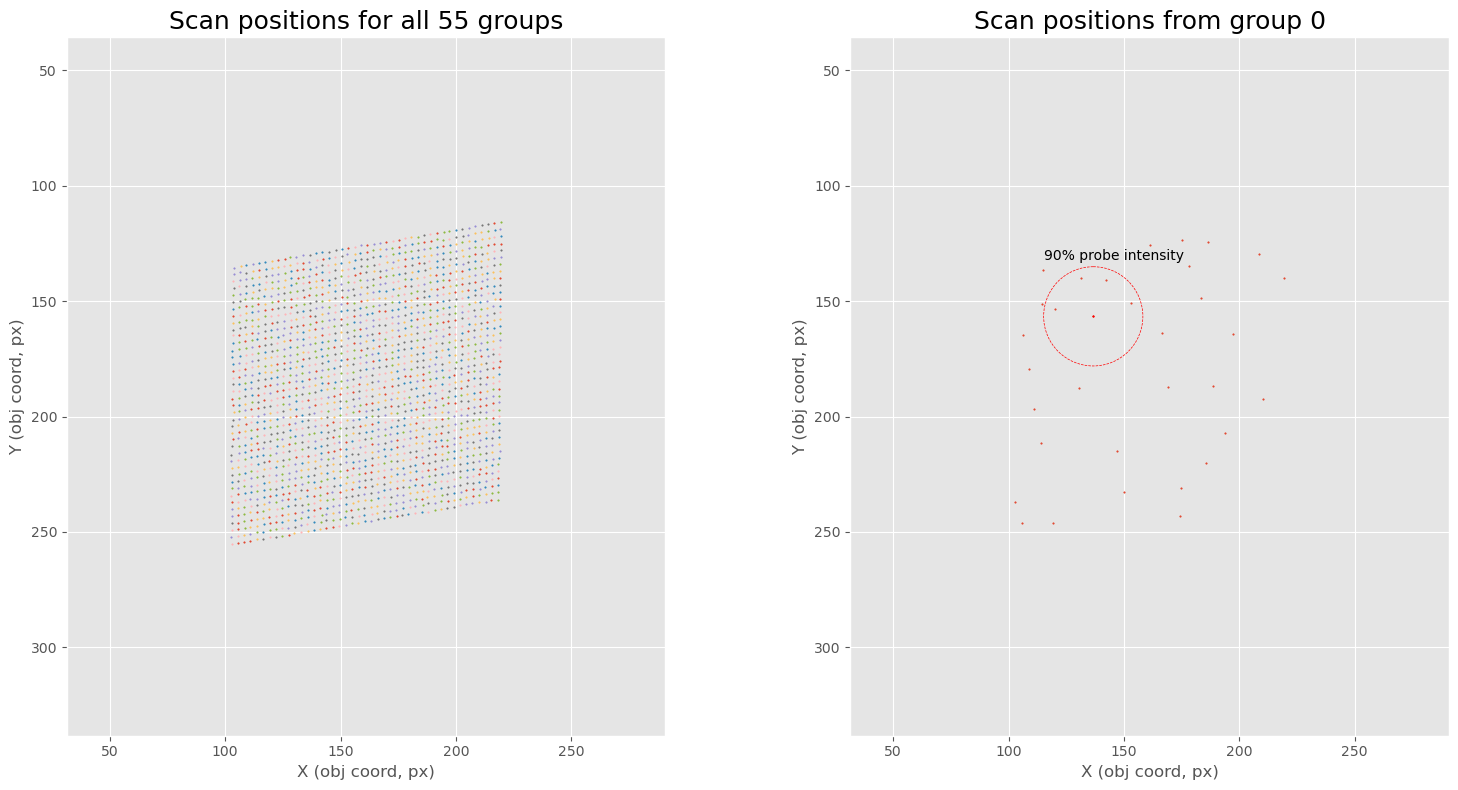

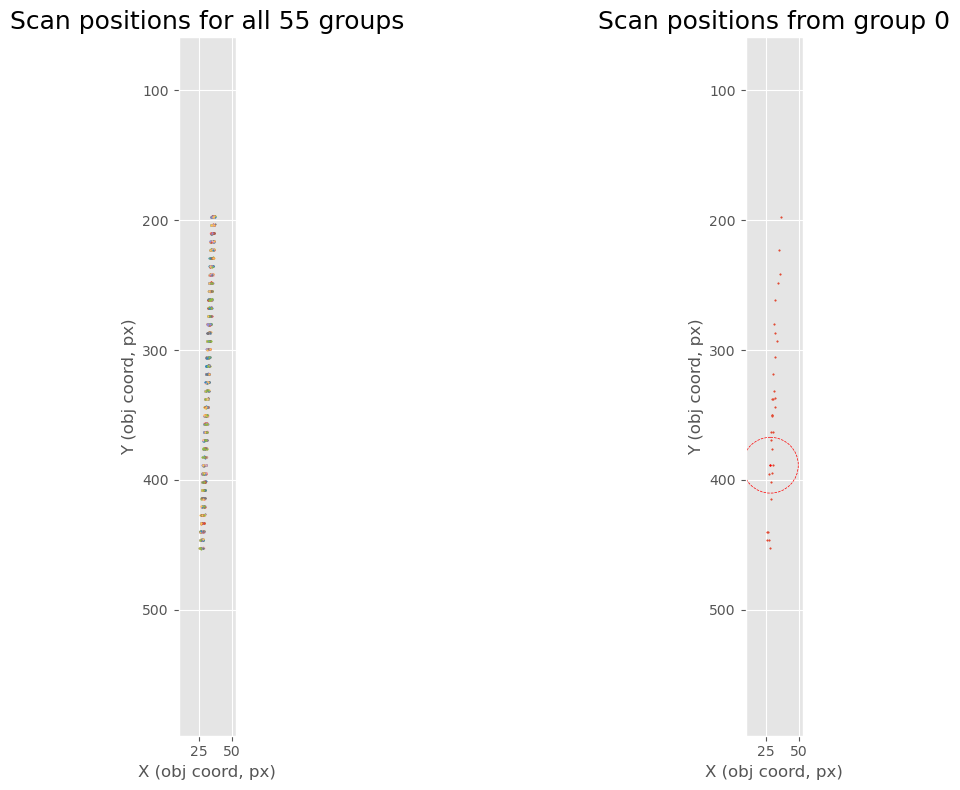

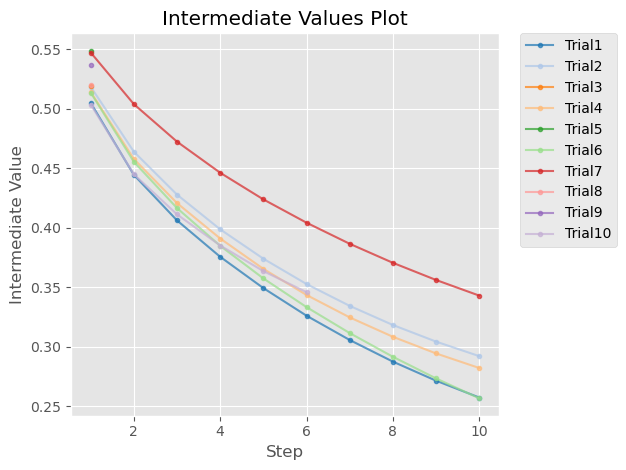

In [16]:
plot_intermediate_values(study)
plt.show()

C:\Users\chiahao3\AppData\Local\Temp\ipykernel_28324\299689176.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


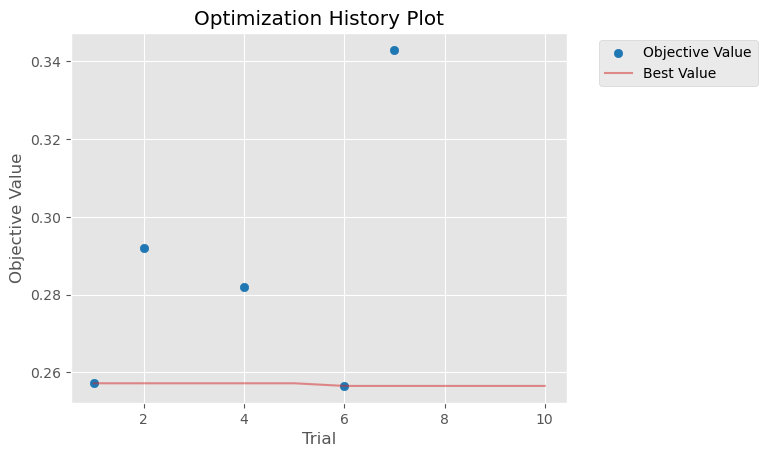

In [17]:
plot_optimization_history(study)
plt.show()